In [1]:
import jnp
import numpy as np
from jax import grad
import time
import matplotlib.pyplot as plt
%matplotlib ipympl

from oblate_lc import TransitParams, lightcurves2, MA_overlap_jax

## planet parameters

In [11]:
# planet/orbit parameters
params = TransitParams()
params.per = 1071.23228
params.a = 560
params.ecc = 0 # 0.062*jnp.pi/180
params.t0 = 253.28699#+2455000
params.phi = 0
params.req = 0.128165741059713 #0.12810
params.omega = 3.5
params.tref = 0
params.w = jnp.pi
params.set_b(0.23457224460854667) # set impact parameter, solves for inclination
params.set_f(0.1) # must be after req
params.u = [0.1, 0.1]

grad_MA = grad(MA_overlap_jax)

# only if you want to plot planet positions
# global PHI
# PHI    = np.linspace(0, 2*np.pi, 200)

times = np.linspace(-1, 1, 10000)


# print(params.counter)

In [12]:
start = time.time()
fluxratio, dist = lightcurves2(params, times, PHI)
print(f'Time: {time.time() - start}')

Time: 1.1372520923614502


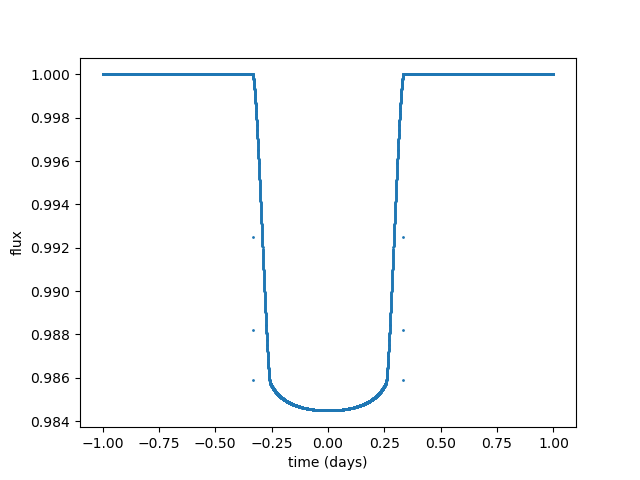

In [13]:
with plt.ioff():
    plt.scatter(times, fluxratio, s = 1)
    plt.xlabel("time (days)")
    plt.ylabel("flux")
    plt.show()
# plt.xlim([-0.265, -0.25])
# plt.ylim([0.983, 0.985])
# plt.ylim([0.980, 0.989])

## Timing Averaged over 10 Runs

In [5]:
# n = 10
# result = timeit.timeit(stmt='X, Y, Z = lightcurves2(params, up, down, PHI)', globals=globals(), number=n)
# print(f"Execution time is {result / n} seconds")


## Profiling

In [6]:
# if __name__ == "__main__":
#     import cProfile
#     from pstats import Stats

#     pr = cProfile.Profile()

#     pr.enable()

#     fluxratio, dist = lightcurves2(params, times, PHI)

#     # plt.plot(times, fluxratio)
#     # plt.xlabel("time (days)")
#     # plt.ylabel("separation distance")
#     # plt.show()

#     # jl.radius = params.req
#     # start = time.time()
    
#     # dist = dist.tolist()
#     # jl.s = jl.convert(jl.Vector, dist)
#     # lap1 = time.time() - start

#     # jl.u_n = np.array(params.u)

#     # lap2 = time.time() - start - lap1
#     # julia_flux = jl.seval("lightcurve(radius, s, u_n)")
#     # julia_flux = julia_flux.to_numpy()
#     # print(type(julia_flux))
#     # lap3 = time.time() - start - lap2
#     # print(lap1)
#     # print(lap2)
#     # print(lap3)
#     pr.disable()
#     pr.dump_stats('output.prof')
#     stats = Stats(pr)
#     stream = open('profiles/jaxgrad_minimize.txt', 'w')
#     stats = Stats('output.prof', stream=stream)
#     stats.sort_stats('cumtime').print_stats()


## Different sampling regions

In [7]:
# single data point, ingress
# up     = params.t0+params.per/2.5329
# down   = params.t0+params.per/2.533
# params.res = 1

# single data point, ingress and z > 1
# up     = params.t0+params.per/2.5332
# down   = params.t0+params.per/2.5334
# params.res = 1

# # single datapoint, egress
# up     = params.t0+params.per/2.5259
# down   = params.t0+params.per/2.526
# params.res = 1

## Using Jax for quartic polynomial

In [17]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

from jax import jit

In [18]:
@jit
def qrt_coeff(params, H2, K2):

    req = params.req
    rpol = params.rpol
    phi_s = params.phi_s
    pos_star = jnp.array(params.pos_star)


    cosphi = jnp.cos(phi_s)
    sinphi = jnp.sin(phi_s)
    H2_TR  = (H2-ppos_star[0])*cosphi + (K2-pos_star[1])*sinphi
    K2_TR  = (pos_star[0]-H2)*sinphi + (K2-pos_star[1])*cosphi
    PHI_2R = phi_p - params.phi_s
    if(abs(PHI_2R)>(2*jnp.pi)):
        PHI_2R = PHI_2R%(2*jnp.pi)
    
    #Calculate the (implicit) polynomial coefficients for the second ellipse in its translated (by (-params.pos_star[0],-H2)) and rotated (by -phi_1) position: AA*x^2 + BB*x*y + CC*y^2 + DD*x + EE*y + FF = 0
    
    cosphi       = jnp.cos(PHI_2R)
    cosphi2      = cosphi*cosphi
    sinphi       = jnp.sin(PHI_2R)
    sinphi2      = sinphi*sinphi
    cosphisinphi = 2.0*cosphi*sinphi
    A22          = req*req
    B22          = rpol*rpol
    tmp0         = (cosphi*H2_TR + sinphi*K2_TR)/A22
    tmp1         = (sinphi*H2_TR - cosphi*K2_TR)/B22
    tmp2         = cosphi*H2_TR + sinphi*K2_TR
    tmp3         = sinphi*H2_TR - cosphi*K2_TR
    
    #Implicit polynomial coefficients for the second ellipse
    
    AA = jnp.square(cosphi)/A22 + jnp.square(sinphi)/B22 # does not change
    BB = cosphisinphi/A22 - cosphisinphi/B22 # does not change
    CC = jnp.square(sinphi)/A22 + jnp.square(cosphi)/B22 # does not change
    DD = -2.0*cosphi*tmp0 - 2.0*sinphi*tmp1
    EE = -2.0*sinphi*tmp0 + 2.0*cosphi*tmp1
    FF = tmp2*tmp2/A22 + tmp3*tmp3/B22 - 1.0
    
    #Create and solve the quartic equation to find intersection points.
    #If execution arrives here, the ellipses are atleast 'close' to intersecting.
    #Coefficients for the quartic polynomial in y are calculated from the two implicit equations. 
    e = (params.rstar_eq**4.0)*AA*AA + params.rstar_pol*params.rstar_pol*(params.rstar_eq*params.rstar_eq*(BB*BB - 2.0*AA*CC) + params.rstar_pol*params.rstar_pol*CC*CC)
    d = 2.0*params.rstar_pol*(params.rstar_pol*params.rstar_pol*CC*EE + params.rstar_eq*params.rstar_eq*(BB*DD - AA*EE))
    c = params.rstar_eq*params.rstar_eq*((params.rstar_pol*params.rstar_pol*(2.0*AA*CC-BB*BB) + DD*DD - 2.0*AA*FF) - 2.0*params.rstar_eq*params.rstar_eq*AA*AA) + params.rstar_pol*params.rstar_pol*(2.0*CC*FF + EE*EE)
    b = 2.0*params.rstar_pol*(params.rstar_eq*params.rstar_eq*(AA*EE - BB*DD) + EE*FF)
    a = (params.rstar_eq*(params.rstar_eq*AA - DD) + FF)*(params.rstar_eq*(params.rstar_eq*AA + DD) + FF)
    
    e = jnp.full((H2.size, 1), e)
    
    cy = jnp.column_stack((a, b, c, d, e))

    return(cy, AA, BB, CC, DD, EE, FF, H2_TR, K2_TR)

In [19]:
H2 = jnp.linspace(-5, 5, 1000)
K2 = jnp.full_like(H2, 0)

w = qrt_coeff(params, H2, K2)
print(w)

TypeError: Cannot interpret value of type <class 'oblate_lc.TransitParams'> as an abstract array; it does not have a dtype attribute